In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


import geopandas as gpd
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import descartes
import math
import matplotlib.colors as mcolors
import pyproj
import folium

In [2]:
wdir = "../Dades/AMS_Observacions/"
crs_latlon = 'EPSG:4326'  # WGS84
crs_utm = "EPSG:32631"

In [3]:
df_no2 = pd.read_csv('../Dades/AMS_Observacions/gene_sconcno2_2023_xvpca_emep_port.csv') 
df_estacions = pd.read_csv('../Dades/AMS_Observacions/XVPCA_info_sconcno2_2023.csv')


# Convert 'Date' column to datetime format
df_no2['Date'] = pd.to_datetime(df_no2['Date'])

# Pivot the dataframe to have each station ID as a column and the Date as the index
# columnas_es = [col for col in df_no2.columns if col.startswith('ES')]
columnas_es =df_no2.drop(['Date'], axis=1)


# Transpose the dataframe to have each station ID as a row and the Date as the column
df_no2_transposed = df_no2.set_index('Date').transpose().reset_index()

# Melt the dataframe to have a 'Value' column for each hour
df_no2_melted = pd.melt(df_no2_transposed, id_vars=['index'], var_name='Date', value_name='no2')

# Rename the 'index' column to 'Station'
df_no2_melted.rename(columns={'index': 'Station'}, inplace=True)

# Drop rows with NaN values
df_no2_melted.dropna(subset=['no2'], inplace=True)

print(df_no2_melted)

# Join the melted dataframe with the station information dataframe
df_obs = pd.merge(df_no2_melted, df_estacions, left_on='Station', right_on='code', how='inner')

# Drop the 'code' column as it is redundant
df_obs.drop(columns=['code','type'], inplace=True)
df_obs['geometry'] = gpd.points_from_xy(df_obs['lon'], df_obs['lat'], crs=crs_utm)
print(df_obs)

        Station                 Date   no2
2       ES1480A  2022-12-31 23:00:00  62.0
3       ES1396A  2022-12-31 23:00:00  60.0
4       ES1992A  2022-12-31 23:00:00  45.0
5       ES0691A  2022-12-31 23:00:00  43.0
6       ES0692A  2022-12-31 23:00:00  45.0
...         ...                  ...   ...
560633  ES2017A  2023-12-31 22:00:00   7.0
560634  ES1930A  2023-12-31 22:00:00   1.0
560635  ES1948A  2023-12-31 22:00:00   3.0
560636  ES1855A  2023-12-31 22:00:00   2.0
560637  ES1854A  2023-12-31 22:00:00   1.0

[529219 rows x 3 columns]
        Station                 Date   no2        lat       lon  \
0       ES1480A  2022-12-31 23:00:00  62.0  41.398762  2.153472   
1       ES1396A  2022-12-31 23:00:00  60.0  41.378803  2.133098   
2       ES1992A  2022-12-31 23:00:00  45.0  41.387273  2.115661   
3       ES0691A  2022-12-31 23:00:00  43.0  41.403716  2.204736   
4       ES0692A  2022-12-31 23:00:00  45.0  41.370760  2.114771   
...         ...                  ...   ...        ...  

In [4]:
# Cargar el shapefile
archivo_shapefile = "../Dades/OpenTransportMap/Barcelona/roadlinks_ES511.shp"
gdf_barcelona = gpd.read_file(archivo_shapefile)
gdf_girona = gpd.read_file("../Dades/OpenTransportMap/Girona/roadlinks_ES512.shp")
gdf_lleida = gpd.read_file("../Dades/OpenTransportMap/Lleida/roadlinks_ES513.shp")
gdf_tarragona = gpd.read_file("../Dades/OpenTransportMap/Tarragona/roadlinks_ES514.shp")

# Concatenate the GeoDataFrames
#gdf = pd.concat([gdf_barcelona, gdf_girona, gdf_lleida, gdf_tarragona], ignore_index=True)

gdf = gdf_barcelona


# Mostrar las primeras filas de la tabla de atributos
#print(gdf['functional'].head())

# Obtener los tipos únicos de la columna 'functional'
tipos_functional = gdf['functional'].unique()

# Asignar valores de prioridad a las categorías
valores_prioridad = {
    'mainRoad': 6 / 6,
    'firstClass': 5 / 6,
    'secondClass': 4 / 6,
    'thirdClass': 3 / 6,
    'fourthClass': 2 / 6,
    'fifthClass': 1 / 6,    
}

# Crear una nueva columna en el GeoDataFrame con los valores de prioridad
gdf['prioridad'] = gdf['functional'].map(valores_prioridad)

# Crear un nuevo DataFrame con las columnas 'sourceid', 'functional' y 'prioridad'
df_transport = gdf[['sourceid', 'prioridad','geometry']].drop_duplicates().reset_index(drop=True)
# Simplificar la geometría
df_transport['geometry'] = df_transport['geometry'].simplify(tolerance=0.01, preserve_topology=True)

print(df_transport.head())

# Guardar el GeoDataFrame en un archivo CSV
#gdf.to_csv("./carreteres.csv", index=False)


    sourceid  prioridad                                         geometry
0  198794320   0.166667  LINESTRING (1.99488 41.66973, 1.99502 41.66971)
1  198935562   0.333333  LINESTRING (2.23387 41.94304, 2.23386 41.94206)
2  198944072   0.333333  LINESTRING (1.68342 41.33341, 1.68353 41.33318)
3  198965364   0.166667  LINESTRING (2.01923 41.57089, 2.01926 41.57088)
4  198965365   0.166667  LINESTRING (2.01857 41.57034, 2.01852 41.57033)


In [26]:
df_caliope = pd.read_csv('../Dades/NO2.csv') 

df_caliope.rename(columns={'sconcno2': 'no2', 'time': 'Date'}, inplace=True)

df_caliope['geometry'] = gpd.points_from_xy(df_caliope['lon'], df_caliope['lat'], crs=crs_utm)

df_combined = pd.concat([df_obs, df_caliope], ignore_index=True)

# Convert df_combined to a GeoDataFrame
df_combined = gpd.GeoDataFrame(df_combined, geometry='geometry', crs=crs_utm)

# Display the first few rows to verify the conversion
df_combined.head()


   Station                 Date   no2        lat       lon  \
0  ES1480A  2022-12-31 23:00:00  62.0  41.398762  2.153472   
1  ES1396A  2022-12-31 23:00:00  60.0  41.378803  2.133098   
2  ES1992A  2022-12-31 23:00:00  45.0  41.387273  2.115661   
3  ES0691A  2022-12-31 23:00:00  43.0  41.403716  2.204736   
4  ES0692A  2022-12-31 23:00:00  45.0  41.370760  2.114771   

               geometry  
0  POINT (2.153 41.399)  
1  POINT (2.133 41.379)  
2  POINT (2.116 41.387)  
3  POINT (2.205 41.404)  
4  POINT (2.115 41.371)  


,Station,Date,no2,lat,lon,geometry
0,ES1480A,2022-12-31 23:00:00,62.0,41.398762,2.153472,POINT (2.153 41.399)
1,ES1396A,2022-12-31 23:00:00,60.0,41.378803,2.133098,POINT (2.133 41.379)
2,ES1992A,2022-12-31 23:00:00,45.0,41.387273,2.115661,POINT (2.116 41.387)
3,ES0691A,2022-12-31 23:00:00,43.0,41.403716,2.204736,POINT (2.205 41.404)
4,ES0692A,2022-12-31 23:00:00,45.0,41.370760,2.114771,POINT (2.115 41.371)


In [10]:
# Agrupar por 'geometry' y calcular la media de 'no2'
df_combined_mean = df_combined.groupby('geometry')['no2'].mean().reset_index()

# Mostrar el resultado
print("Max NO2:", df_combined_mean['no2'].max())
print("Min NO2:", df_combined_mean['no2'].min())

Max NO2: 34.580633549316055
Min NO2: 0.00010403053067096775


In [40]:
# Use a smaller subset of the data for kriging
print(df_combined_mean.shape)
subset_size = 10000  # Adjust this value based on available memory
df_subset = df_combined_mean.sample(n=subset_size, random_state=42)

ok = OrdinaryKriging(
    df_subset.geometry.apply(lambda geom: geom.x), 
    df_subset.geometry.apply(lambda geom: geom.y), 
    df_subset['no2'].values,
    variogram_model='linear',
    verbose=True, 
    enable_plotting=False,
    nlags=25
)

(82908, 2)
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 3.534096855390133e-28
Nugget: 0.2044078436300267 

Calculating statistics on variogram model fit...


In [41]:
# Crear un GeoDataFrame con las ubicaciones de observación
#points = [(2.009802, 41.39216), (1.191975, 41.11588), (2.237875, 41.44398), (2.082141, 41.32177)]

#obs_locations = gpd.GeoDataFrame(pi, geometry='geometry', crs=crs_utm)

obs_locations = gpd.GeoDataFrame(
    {'geometry': [Point(2.009802, 41.39216), Point(1.191975, 41.11588), Point(2.237875, 41.44398), Point(2.082141, 41.32177)]},
    crs=crs_utm
)

# Convertir las coordenadas a UTM
#obs_locations = obs_locations.to_crs(crs_utm)

print(obs_locations)

# Ejecutar el modelo de kriging para predecir los valores en estas ubicaciones
z, ss = ok.execute('points', obs_locations.geometry.x, obs_locations.geometry.y)

# Mostrar los resultados
obs_locations['predicted_no2'] = z
print(obs_locations)

               geometry
0   POINT (2.01 41.392)
1  POINT (1.192 41.116)
2  POINT (2.238 41.444)
3  POINT (2.082 41.322)
Executing Ordinary Kriging...

               geometry  predicted_no2
0   POINT (2.01 41.392)       0.015324
1  POINT (1.192 41.116)       0.015324
2  POINT (2.238 41.444)       0.015324
3  POINT (2.082 41.322)       0.015324


In [44]:
from scipy.spatial import cKDTree
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# Crear GeoDataFrame con puntos de predicción
obs_locations = gpd.GeoDataFrame(
    {'geometry': [Point(2.009802, 41.39216), Point(1.191975, 41.11588), 
                  Point(2.237875, 41.44398), Point(2.082141, 41.32177)]},
    crs=crs_utm
)

# Extraer coordenadas y valores del dataset conocido
coords = np.array([(geom.x, geom.y) for geom in df_combined_mean.geometry])
values = df_combined_mean['no2'].values

# Crear el árbol KD
tree = cKDTree(coords)

# Función IDW
def idw(x, y, tree, coords, values, power=2):
    """
    Interpolación por inverso de la distancia (IDW).
    - x, y: Coordenadas de predicción
    - tree: KDTree construido con los datos conocidos
    - coords: Coordenadas conocidas
    - values: Valores conocidos
    - power: Peso de la distancia
    """
    # Encontrar distancias y vecinos
    distances, idx = tree.query(np.c_[x, y], k=len(coords))
    
    # Manejo de distancias 0 (puntos coincidentes)
    distances[distances == 0] = 1e-10  # Evitar división por cero
    
    # Calcular pesos inversos a las distancias
    weights = 1 / distances**power
    
    # Normalizar los pesos
    weights /= np.sum(weights, axis=1, keepdims=True)
    
    # Calcular valores interpolados
    interpolated_values = np.sum(weights * values[idx], axis=1)
    return interpolated_values

# Coordenadas de los puntos a predecir
prediction_coords = np.array([(geom.x, geom.y) for geom in obs_locations.geometry])
x_pred, y_pred = prediction_coords[:, 0], prediction_coords[:, 1]

# Aplicar IDW a los puntos
obs_locations['predicted_value'] = idw(x_pred, y_pred, tree, coords, values)

print(obs_locations)


               geometry  predicted_value
0   POINT (2.01 41.392)         0.466110
1  POINT (1.192 41.116)         0.193046
2  POINT (2.238 41.444)         0.289827
3  POINT (2.082 41.322)         0.389294


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 10743375, number of used features: 5
[LightGBM] [Info] Start training from score 0.635825
Mean Squared Error: 9.6576
R^2 Score: 0.5022
Mean Absolute Error: 0.5132
Root Mean Squared Error: 3.1077


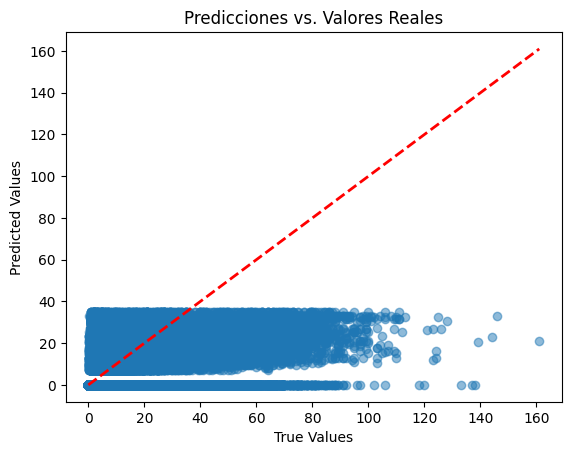

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import lightgbm as lgb

# Convertir la columna 'Date' a datetime si no lo está ya
df_combined['Date'] = pd.to_datetime(df_combined['Date'])

# Extraer características de tiempo
df_combined['year'] = df_combined['Date'].dt.year
df_combined['month'] = df_combined['Date'].dt.month
df_combined['day'] = df_combined['Date'].dt.day
df_combined['hour'] = df_combined['Date'].dt.hour

# Transformaciones cíclicas para variables de tiempo
df_combined['month_sin'] = np.sin(2 * np.pi * df_combined['month'] / 12)
df_combined['month_cos'] = np.cos(2 * np.pi * df_combined['month'] / 12)
df_combined['hour_sin'] = np.sin(2 * np.pi * df_combined['hour'] / 24)
df_combined['hour_cos'] = np.cos(2 * np.pi * df_combined['hour'] / 24)

# Seleccionar características y variable objetivo
X = df_combined[['month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'year']]
y = df_combined['no2']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el dataset de LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Definir los parámetros del modelo
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Entrenar el modelo
# Entrenar el modelo
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],  # Conjunto de validación
    num_boost_round=1000,
)

# Hacer predicciones
y_pred = model.predict(X_test)


# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

# Visualizar predicciones vs. valores reales
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicciones vs. Valores Reales")
plt.show()


In [ ]:
data = {
    'ID': [1, 2, 3, 4, 5],
    'Date': ['2023-01-01 00:00', '2023-01-01 00:00', '2023-01-01 00:00', '2023-01-01 01:00', '2023-01-01 02:00'],
    'Longitude': [2.082141, 2.237875, 2.009802, 2.082141, 2.082141],
    'Latitude': [41.32177, 41.44398, 41.39216, 41.32177, 41.32177],
    'Value': [30.9, 17.0, 19.1, 28.3, 24.7]
}

df_points = pd.DataFrame(data)
print(df_points)

In [51]:
"""from scipy.interpolate import griddata
lat_grid = np.linspace(df_combined["lat"].min(), df_combined["lat"].max(), 100)  # 100 puntos de latitud
lon_grid = np.linspace(df_combined["lon"].min(), df_combined["lon"].max(), 100)  # 100 puntos de longitud
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)  # Crear la malla de la rejilla

# Realizar la interpolación bilineal
points = np.array([df_combined["lat"], df_combined["lon"]]).T  # Puntos de entrada (lat, lon)
values = df_combined["no2"]  # Valores de NO2 en los puntos
grid_no2 = griddata(points, values, (lat_mesh, lon_mesh), method="linear")  # Interpolación

# Visualización del resultado
plt.figure(figsize=(8, 6))
plt.contourf(lon_mesh, lat_mesh, grid_no2, levels=100, cmap="viridis")  # Contorno interpolado
plt.colorbar(label="NO2 Concentration")
plt.scatter(df_combined["lon"], df_combined["lat"], c=df_combined["no2"], cmap="viridis", edgecolor="k", label="Data Points")  # Puntos originales
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Interpolación Bilineal de NO2")
plt.show()"""


'from scipy.interpolate import griddata\nlat_grid = np.linspace(df_combined["lat"].min(), df_combined["lat"].max(), 100)  # 100 puntos de latitud\nlon_grid = np.linspace(df_combined["lon"].min(), df_combined["lon"].max(), 100)  # 100 puntos de longitud\nlon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)  # Crear la malla de la rejilla\n\n# Realizar la interpolación bilineal\npoints = np.array([df_combined["lat"], df_combined["lon"]]).T  # Puntos de entrada (lat, lon)\nvalues = df_combined["no2"]  # Valores de NO2 en los puntos\ngrid_no2 = griddata(points, values, (lat_mesh, lon_mesh), method="linear")  # Interpolación\n\n# Visualización del resultado\nplt.figure(figsize=(8, 6))\nplt.contourf(lon_mesh, lat_mesh, grid_no2, levels=100, cmap="viridis")  # Contorno interpolado\nplt.colorbar(label="NO2 Concentration")\nplt.scatter(df_combined["lon"], df_combined["lat"], c=df_combined["no2"], cmap="viridis", edgecolor="k", label="Data Points")  # Puntos originales\nplt.xlabel("Longitude")\n

In [7]:
"""# Extract x and y coordinates from the geometry column
x_coords = df_combined.geometry.apply(lambda geom: geom.x)
y_coords = df_combined.geometry.apply(lambda geom: geom.y)

ok = OrdinaryKriging(
    x_coords, y_coords, df_combined['no2'].values,
    variogram_model='gaussian',
    verbose=True, 
    enable_plotting=False,
    nlags=25
)"""

"# Extract x and y coordinates from the geometry column\nx_coords = df_combined.geometry.apply(lambda geom: geom.x)\ny_coords = df_combined.geometry.apply(lambda geom: geom.y)\n\nok = OrdinaryKriging(\n    x_coords, y_coords, df_combined['no2'].values,\n    variogram_model='gaussian',\n    verbose=True, \n    enable_plotting=False,\n    nlags=25\n)"

In [8]:
"""from multiprocessing import Pool

stations = gpd.GeoDataFrame(df_obs[['Station', 'geometry']].drop_duplicates().reset_index(drop=True), geometry='geometry')
stations['buffer'] = stations.geometry.buffer(100)

# Leer las carreteras desde el DataFrame
carreteras = df_transport

# Crear un índice espacial para las carreteras
carreteras_sindex = carreteras.sindex

def encontrar_tipo_carretera(buffer):
    # Encontrar las carreteras que intersectan con el buffer
    posibles_intersecciones = list(carreteras_sindex.intersection(buffer.bounds))
    carreteras_intersectadas = carreteras.iloc[posibles_intersecciones]
    
    # Filtrar las carreteras que realmente intersectan con el buffer
    intersecciones = carreteras_intersectadas[carreteras_intersectadas.intersects(buffer)]
    
    if not intersecciones.empty:
        intersecciones['buffer_id'] = buffer.name
        return intersecciones[['buffer_id', 'sourceid', 'prioridad']]
    else:
        return pd.DataFrame(columns=['buffer_id', 'sourceid', 'prioridad'])

# Procesar los buffers en paralelo
with Pool() as pool:
    resultados = pool.map(encontrar_tipo_carretera, stations['buffer'])

# Combinar los resultados
resultados_df = pd.concat(resultados, ignore_index=True)

# Mostrar resultados
print(resultados_df)"""


"from multiprocessing import Pool\n\nstations = gpd.GeoDataFrame(df_obs[['Station', 'geometry']].drop_duplicates().reset_index(drop=True), geometry='geometry')\nstations['buffer'] = stations.geometry.buffer(100)\n\n# Leer las carreteras desde el DataFrame\ncarreteras = df_transport\n\n# Crear un índice espacial para las carreteras\ncarreteras_sindex = carreteras.sindex\n\ndef encontrar_tipo_carretera(buffer):\n    # Encontrar las carreteras que intersectan con el buffer\n    posibles_intersecciones = list(carreteras_sindex.intersection(buffer.bounds))\n    carreteras_intersectadas = carreteras.iloc[posibles_intersecciones]\n    \n    # Filtrar las carreteras que realmente intersectan con el buffer\n    intersecciones = carreteras_intersectadas[carreteras_intersectadas.intersects(buffer)]\n    \n    if not intersecciones.empty:\n        intersecciones['buffer_id'] = buffer.name\n        return intersecciones[['buffer_id', 'sourceid', 'prioridad']]\n    else:\n        return pd.DataFrame